<a href="https://colab.research.google.com/github/egagli/amath563/blob/main/labs/3/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Pytorch Operators and Optimizers

## Assignment: Fashion MNIST Classification

In Lab3, we will use the Fashion MNIST dataset (see video recording for explanation of Fashion MNIST dataset). Similar to previous Lab2, you should design a fully-connected network as well as the pytorch based training/validation/testing process on the classification task. But differently, we will dive into the optimizers, operations or modules that we have learned in the lectures, and to see how they can benefit the capacity of your model.



1. Try different optimizers including RMSProp, Adam and SGD(You can find the corresponding functions in the torch.optim library). Log your training loss and test accuracy. Comparing these optimizers, how do they work? Which one is the best for this task and try to explain it.

2. Analyze the overfitting/underfitting situation of your model. Try to use regularization like L2/L1, Dropout layers, etc. to improve your performance. How does your regularization work? And how do you balance your regularization and the loss optimization?

3. Try different initialization ways like random normal, Xavier and He (Kaiming) etc. How can these initialization affect your training process and performance? 

4. Try normalization like batch normalization or layer normalization, whether these normalization methods can help your training or improve your performance?

5. To further improve the performance, you can also choose your own hyperparameters, including:
- Number of layers
- Number of neurons in each layer
- Learning rate
- Number of training epochs

For the comparing of different optimizers, regularization, initialization, normalization and hyper-parameters, you are recommended to form a table of the comparison results.  Report your loss as ”loss curve” and accuracy for different settings and draw conclusions. **You can split a small validation set from the training set to help you analyze the effectiveness of different modules better.**

For the convenient implementation of different optimizers, regularization, initialization and normalization, you can always check the tutorial of pytorch library (https://pytorch.org/tutorials/) for some useful funuctions and examples.

In [ ]:
import torch
import torchvision
import tqdm
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil

train_batch_size =  100 # Define train batch size
test_batch_size  =  100 # Define test batch size (can be larger than train batch size)


train_data = torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_data = torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_data, val_data = torch.utils.data.random_split(train_data, [floor(len(train_data)*0.8), floor(len(train_data)*0.2)])
train_loader = torch.utils.data.DataLoader(train_data,  batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data,  batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

input_dim = 784

In [ ]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    self.layer2 = nn.Linear(300, 150)
    self.layer3 = nn.Linear(150, 75)
    self.layer4 = nn.Linear(75, 10) 
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [ ]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = optimizers[1]
loss_fn   = nn.CrossEntropyLoss() 

epochs = 30

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 30/30 [05:59<00:00, 11.99s/it]


Text(0.5, 0.98, 'Adam \n lr = 0.0001 epochs = 30 \n Max Accuracy = 0.930')

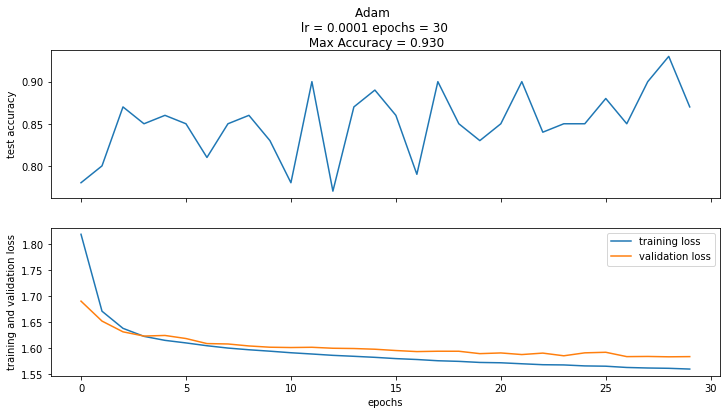

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [ ]:
#for item in accuracy_list:
#  print(item)
#for item in train_loss_list:
#  print(item)
#for item in val_loss_list:
#  print(item)

## 1. Try different optimizers including RMSProp, Adam and SGD(You can find the corresponding functions in the torch.optim library). Log your training loss and test accuracy. Comparing these optimizers, how do they work? Which one is the best for this task and try to explain it.

In [ ]:
acc_sgd=[0.3600000143,0.5400000215,0.6000000238,0.6200000048,0.7599999905,0.7599999905,0.7799999714,0.7599999905,0.6399999857,0.7400000095,0.8199999928,0.8000000119,0.7799999714,0.8000000119,0.7400000095,0.8799999952,0.7200000286,0.7599999905,0.8399999738,0.7799999714,0.8199999928,0.8000000119,0.8199999928,0.7400000095,0.8999999762,0.8000000119,0.8000000119,0.8799999952,0.8000000119,0.7400000095]
acc_adam=[0.7599999905,0.8999999762,0.8399999738,0.8399999738,0.8999999762,0.8999999762,0.8799999952,0.8600000143,0.8999999762,0.9399999976,0.8399999738,0.8399999738,0.8399999738,0.8399999738,0.8600000143,0.8199999928,0.9800000191,0.8600000143,0.9200000167,0.9399999976,0.9200000167,0.8199999928,0.9200000167,0.9599999785,0.8999999762,0.8199999928,0.8999999762,0.9800000191,0.9399999976,0.8600000143]
acc_rmsprop=[0.8000000119,0.8799999952,0.7599999905,0.7200000286,0.7400000095,0.7799999714,0.7200000286,0.8000000119,0.8000000119,0.8199999928,0.7400000095,0.7799999714,0.8799999952,0.8000000119,0.8000000119,0.7599999905,0.8600000143,0.8000000119,0.8199999928,0.8399999738,0.8600000143,0.8600000143,0.7799999714,0.8000000119,0.8199999928,0.7799999714,0.8799999952,0.8799999952,0.8199999928,0.8199999928]
train_loss_sgd=[2.293080091,2.141797066,1.904837251,1.834599853,1.758315682,1.714200258,1.694371462,1.685354233,1.678438544,1.673794508,1.669273734,1.665959716,1.66308248,1.660287738,1.657434583,1.655570626,1.653510451,1.651073575,1.649296403,1.647516608,1.645679116,1.644156575,1.642973065,1.641498804,1.640251517,1.638855457,1.637753606,1.6368469,1.635491729,1.634356141]
train_loss_adam=[1.760677218,1.64522779,1.625098825,1.615772843,1.609743595,1.604772568,1.600561738,1.596510172,1.593544483,1.589552283,1.587705374,1.584816813,1.58312571,1.580901027,1.578140974,1.575583577,1.575028062,1.572969794,1.569610119,1.568166852,1.567069888,1.563863516,1.562929511,1.561226487,1.559477687,1.557685733,1.556758761,1.555186152,1.554550171,1.552998781]
train_loss_rmsprop=[1.751554847,1.68819046,1.675928116,1.668939114,1.66363883,1.658946753,1.656076193,1.652784228,1.65040791,1.648086786,1.646465898,1.644263744,1.643014669,1.640619993,1.639723897,1.637830496,1.636268377,1.635208964,1.634079099,1.63293314,1.631302595,1.63051796,1.628911734,1.627446651,1.626635671,1.62592864,1.62440753,1.623809934,1.622925401,1.621634126]
val_loss_sgd=[2.27363801,2.005608082,1.855468988,1.781589508,1.730735898,1.704077482,1.68894577,1.681389451,1.675464511,1.670607686,1.669108629,1.665825605,1.661953449,1.65916419,1.657814384,1.655759573,1.655345798,1.652172327,1.651123762,1.659386158,1.652827859,1.646945715,1.647010684,1.64636445,1.646479011,1.645468354,1.643261075,1.642461061,1.642606616,1.641924024]
val_loss_adam=[1.669631362,1.628397465,1.619390249,1.611227274,1.607228756,1.605820179,1.598917484,1.612489343,1.600524664,1.595178127,1.592600703,1.595243931,1.598053098,1.589412093,1.583054662,1.59353745,1.581564665,1.582463741,1.582298398,1.579756856,1.581231952,1.581391096,1.57875514,1.581992388,1.57781744,1.578256965,1.57596612,1.574449658,1.575351596,1.576781511]
val_loss_rmsprop=[1.698952794,1.685013175,1.670212507,1.669555187,1.668602228,1.665557504,1.657603621,1.657444477,1.655132174,1.653201222,1.652430415,1.653460979,1.651396155,1.649748206,1.651683927,1.653443456,1.64861691,1.649386048,1.648332715,1.649724364,1.65016377,1.6464504,1.649963617,1.646165133,1.647703052,1.649430156,1.651657462,1.648164988,1.648165226,1.64890182]

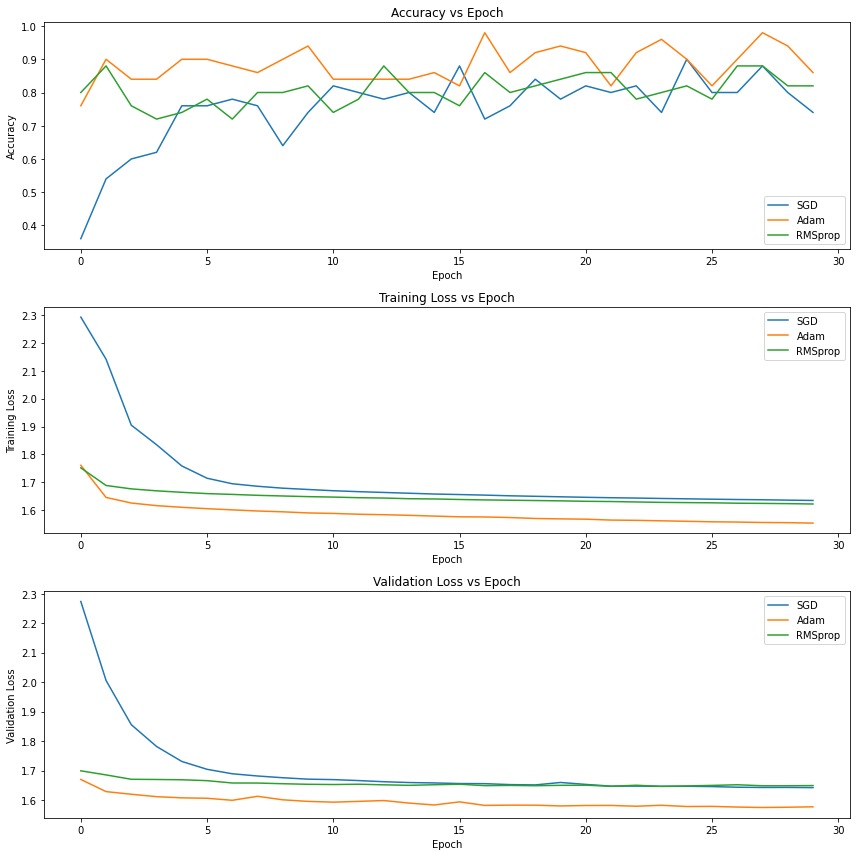

In [ ]:
f,ax=plt.subplots(nrows=3,figsize=(12,12))
ax[0].plot(acc_sgd,label='SGD')
ax[0].plot(acc_adam,label='Adam')
ax[0].plot(acc_rmsprop,label='RMSprop')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs Epoch')
ax[0].legend()

ax[1].plot(train_loss_sgd,label='SGD')
ax[1].plot(train_loss_adam,label='Adam')
ax[1].plot(train_loss_rmsprop,label='RMSprop')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Training Loss')
ax[1].set_title('Training Loss vs Epoch')
ax[1].legend()

ax[2].plot(val_loss_sgd,label='SGD')
ax[2].plot(val_loss_adam,label='Adam')
ax[2].plot(val_loss_rmsprop,label='RMSprop')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Validation Loss')
ax[2].set_title('Validation Loss vs Epoch')
ax[2].legend()
plt.tight_layout()

Out of the 3 optimizers tested (SGD w/ lr=0.01, Adam w/ lr=0.0001, RMSprop w/ lr=0.0001), Adam performs with the best accuracy across almost all epochs. Also, the training and validaion loss is consistently lower using Adam. The times were all comparable, with SGD taking 5:53, Adam taking 6:32, and RMSprop taking 6:12. For the increased accuracy, an extra 30 seconds is a small price to pay.

## 2. Analyze the overfitting/underfitting situation of your model. Try to use regularization like L2/L1, Dropout layers, etc. to improve your performance. How does your regularization work? And how do you balance your regularization and the loss optimization?


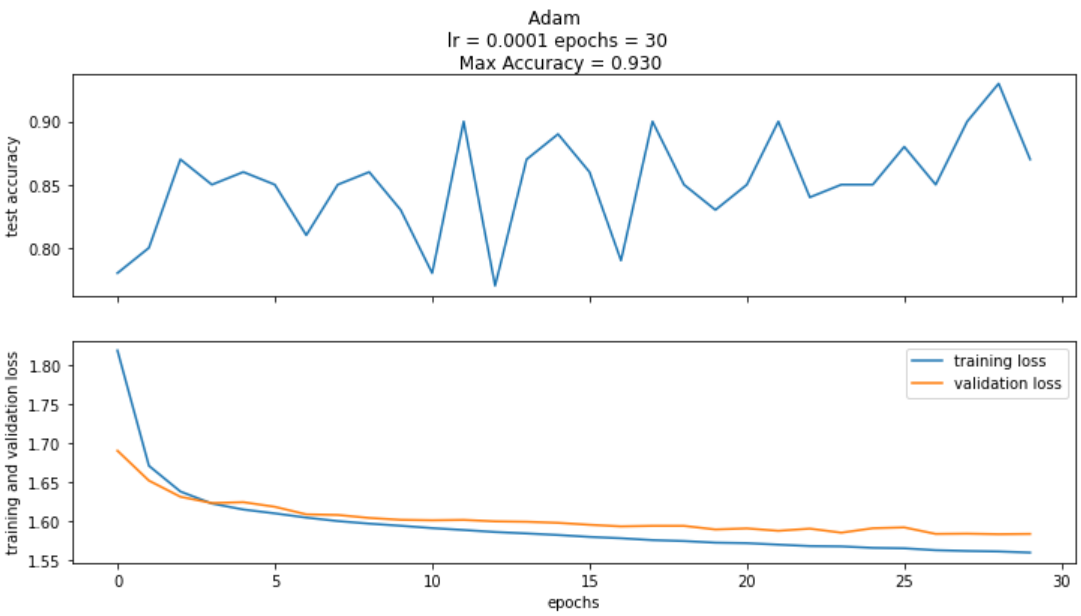

Based on the graph above, it seems we are overfitting. This is apparent where the validation loss stagnates and the training loss continues to decrease. This begins around epoch 4. To combat this, we regularize. We will utilize L1, L2, and dropout to try to minimize overfitting. First let's try dropout.

In [ ]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    self.layer2 = nn.Linear(300, 150)
    self.layer3 = nn.Linear(150, 75)
    self.layer4 = nn.Linear(75, 10) 
    self.dropout = nn.Dropout(0.3)
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = self.dropout(F.relu(self.layer1(x)))
    x = self.dropout(F.relu(self.layer2(x)))
    x = self.dropout(F.relu(self.layer3(x)))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [ ]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = optimizers[1]
loss_fn   = nn.CrossEntropyLoss() 

epochs = 30

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 30/30 [06:15<00:00, 12.51s/it]


Text(0.5, 0.98, 'Adam (with dropout = 0.3) \n lr = 0.0001 epochs = 30 \n Max Accuracy = 0.940')

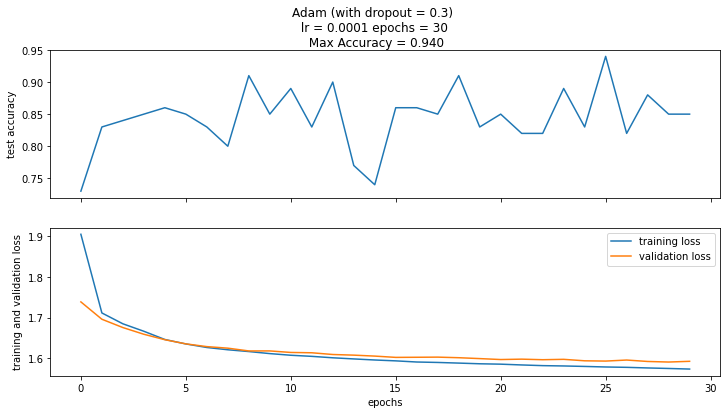

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam (with dropout = 0.3) \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

So it seems dropout reduces overfitting! This is evident in the crossover event between training and validation loss has been delayed. Now lets try L2. 

In [ ]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    self.layer2 = nn.Linear(300, 150)
    self.layer3 = nn.Linear(150, 75)
    self.layer4 = nn.Linear(75, 10) 
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [ ]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001,weight_decay=0.3)
loss_fn   = nn.CrossEntropyLoss() 

epochs = 30

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 30/30 [26:30<00:00, 53.01s/it]


Text(0.5, 0.98, 'Adam (with weight decay = 0.3) \n lr = 0.0001 epochs = 30 \n Max Accuracy = 0.200')

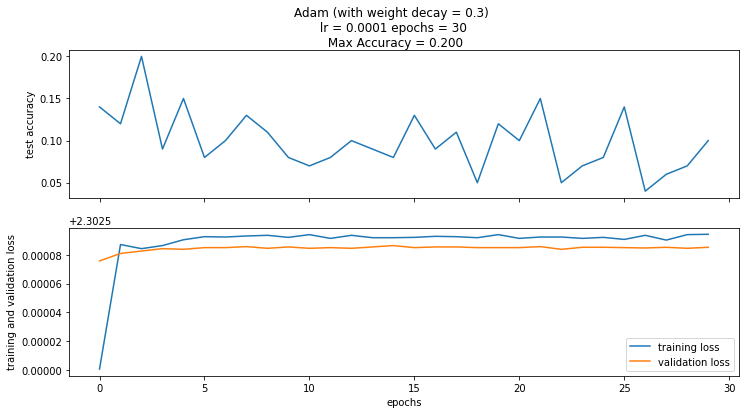

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam (with weight decay = 0.3) \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

I applied L2 regularization in the Adam definition, setting the weight decay option which acts as an L2 penalty. So it seems L2 regularization has similar effect as dropout but took much longer and must be paired with a lower learning rate, as my attempt above took 27 minutes for that garbage :( . Perhaps combining could further reduce overfitting? Regularization and loss optimization must be tricky to balance, there is a sweet spot. Making sure the model is not overfit is the priority, then we can focus on loss optimization.

## 3. Try different initialization ways like random normal, Xavier and He (Kaiming) etc. How can these initialization affect your training process and performance? 


In [ ]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    nn.init.normal_(self.layer1.weight)
    self.layer2 = nn.Linear(300, 150)
    self.layer3 = nn.Linear(150, 75)
    self.layer4 = nn.Linear(75, 10) 
    self.dropout = nn.Dropout(0.3)
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = self.dropout(F.relu(self.layer1(x)))
    x = self.dropout(F.relu(self.layer2(x)))
    x = self.dropout(F.relu(self.layer3(x)))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [ ]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = optimizers[1]
loss_fn   = nn.CrossEntropyLoss() 

epochs = 10

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 10/10 [02:04<00:00, 12.47s/it]


Text(0.5, 0.98, 'Adam (with random normal initialization) \n lr = 0.0001 epochs = 10 \n Max Accuracy = 0.730')

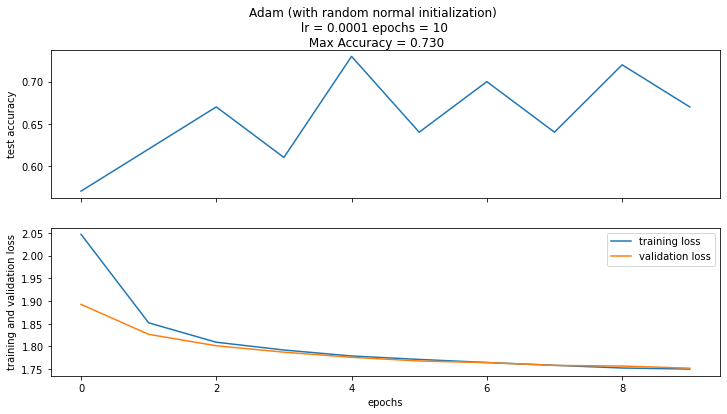

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam (with random normal initialization) \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [ ]:
for item in accuracy_list:
  print(item)

0.5699999928474426
0.6200000047683716
0.6700000166893005
0.6100000143051147
0.7300000190734863
0.6399999856948853
0.699999988079071
0.6399999856948853
0.7200000286102295
0.6700000166893005


In [ ]:
for item in train_loss_list:
  print(item)

2.046879529953003
1.852076768875122
1.8093922138214111
1.7922619581222534
1.7790883779525757
1.771563172340393
1.7647854089736938
1.7586073875427246
1.7526706457138062
1.7503448724746704


In [ ]:
for item in val_loss_list:
  print(item)

1.892640233039856
1.8267544507980347
1.8015693426132202
1.7874921560287476
1.77622652053833
1.7680974006652832
1.764565110206604
1.758400559425354
1.7570135593414307
1.75233793258667


In [ ]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    nn.init.xavier_normal_(self.layer1.weight)
    self.layer2 = nn.Linear(300, 150)
    self.layer3 = nn.Linear(150, 75)
    self.layer4 = nn.Linear(75, 10) 
    self.dropout = nn.Dropout(0.3)
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = self.dropout(F.relu(self.layer1(x)))
    x = self.dropout(F.relu(self.layer2(x)))
    x = self.dropout(F.relu(self.layer3(x)))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [ ]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = optimizers[1]
loss_fn   = nn.CrossEntropyLoss() 

epochs = 10

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 10/10 [02:12<00:00, 13.25s/it]


Text(0.5, 0.98, 'Adam (with xavier initialization) \n lr = 0.0001 epochs = 10 \n Max Accuracy = 0.910')

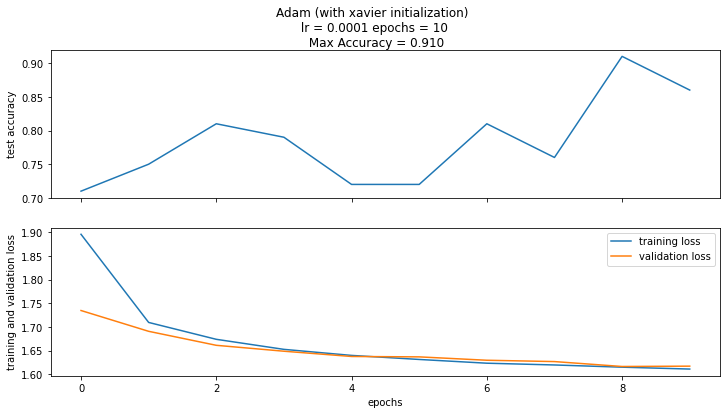

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam (with xavier initialization) \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [ ]:
for item in accuracy_list:
  print(item)

0.7099999785423279
0.75
0.8100000023841858
0.7900000214576721
0.7200000286102295
0.7200000286102295
0.8100000023841858
0.7599999904632568
0.9100000262260437
0.8600000143051147


In [ ]:
for item in train_loss_list:
  print(item)

1.8955177068710327
1.7095654010772705
1.6739681959152222
1.6527773141860962
1.640026569366455
1.6314769983291626
1.6235806941986084
1.6198538541793823
1.6151989698410034
1.611222505569458


In [ ]:
for item in val_loss_list:
  print(item)

1.7347257137298584
1.6908403635025024
1.6613222360610962
1.6488558053970337
1.6377604007720947
1.636930227279663
1.6298094987869263
1.6270115375518799
1.6166521310806274
1.6173533201217651


In [ ]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    nn.init.kaiming_normal_(self.layer1.weight)
    self.layer2 = nn.Linear(300, 150)
    self.layer3 = nn.Linear(150, 75)
    self.layer4 = nn.Linear(75, 10) 
    self.dropout = nn.Dropout(0.3)
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = self.dropout(F.relu(self.layer1(x)))
    x = self.dropout(F.relu(self.layer2(x)))
    x = self.dropout(F.relu(self.layer3(x)))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [ ]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = optimizers[1]
loss_fn   = nn.CrossEntropyLoss() 

epochs = 10

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 10/10 [02:06<00:00, 12.66s/it]


Text(0.5, 0.98, 'Adam (with kaiming initialization) \n lr = 0.0001 epochs = 10 \n Max Accuracy = 0.890')

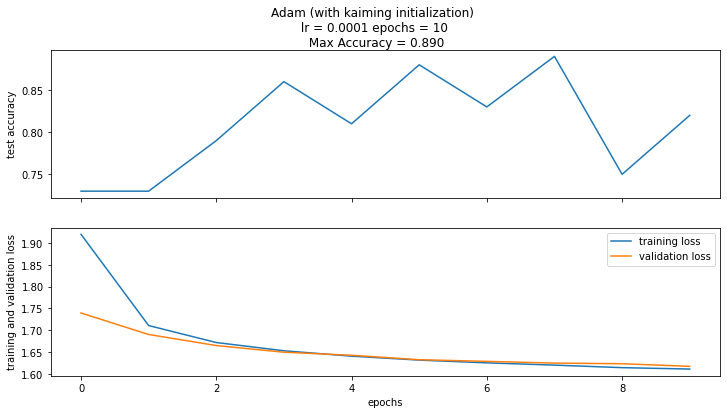

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam (with kaiming initialization) \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [ ]:
for item in accuracy_list:
  print(item)

0.7300000190734863
0.7300000190734863
0.7900000214576721
0.8600000143051147
0.8100000023841858
0.8799999952316284
0.8299999833106995
0.8899999856948853
0.75
0.8199999928474426


In [ ]:
for item in train_loss_list:
  print(item)

1.920167326927185
1.7108066082000732
1.6718379259109497
1.65297269821167
1.6405621767044067
1.6315207481384277
1.625211477279663
1.6200207471847534
1.61421799659729
1.6109809875488281


In [ ]:
for item in val_loss_list:
  print(item)

1.7396397590637207
1.6903107166290283
1.6649307012557983
1.6496456861495972
1.642621636390686
1.6324602365493774
1.6285898685455322
1.6246392726898193
1.6232043504714966
1.6172341108322144


In [36]:
acc_rn=[0.5699999928,0.6200000048,0.6700000167,0.6100000143,0.7300000191,0.6399999857,0.6999999881,0.6399999857,0.7200000286,0.6700000167]
acc_xavier=[0.7099999785,0.75,0.8100000024,0.7900000215,0.7200000286,0.7200000286,0.8100000024,0.7599999905,0.9100000262,0.8600000143]
acc_kaiming=[0.7300000191,0.7300000191,0.7900000215,0.8600000143,0.8100000024,0.8799999952,0.8299999833,0.8899999857,0.75,0.8199999928]
train_loss_rn=[2.04687953,1.852076769,1.809392214,1.792261958,1.779088378,1.771563172,1.764785409,1.758607388,1.752670646,1.750344872]
train_loss_xavier=[1.895517707,1.709565401,1.673968196,1.652777314,1.640026569,1.631476998,1.623580694,1.619853854,1.61519897,1.611222506]
train_loss_kaiming=[1.920167327,1.710806608,1.671837926,1.652972698,1.640562177,1.631520748,1.625211477,1.620020747,1.614217997,1.610980988]
val_loss_rn=[1.892640233,1.826754451,1.801569343,1.787492156,1.776226521,1.768097401,1.76456511,1.758400559,1.757013559,1.752337933]
val_loss_xavier=[1.734725714,1.690840364,1.661322236,1.648855805,1.637760401,1.636930227,1.629809499,1.627011538,1.616652131,1.61735332]
val_loss_kaiming=[1.739639759,1.690310717,1.664930701,1.649645686,1.642621636,1.632460237,1.628589869,1.624639273,1.62320435,1.617234111]

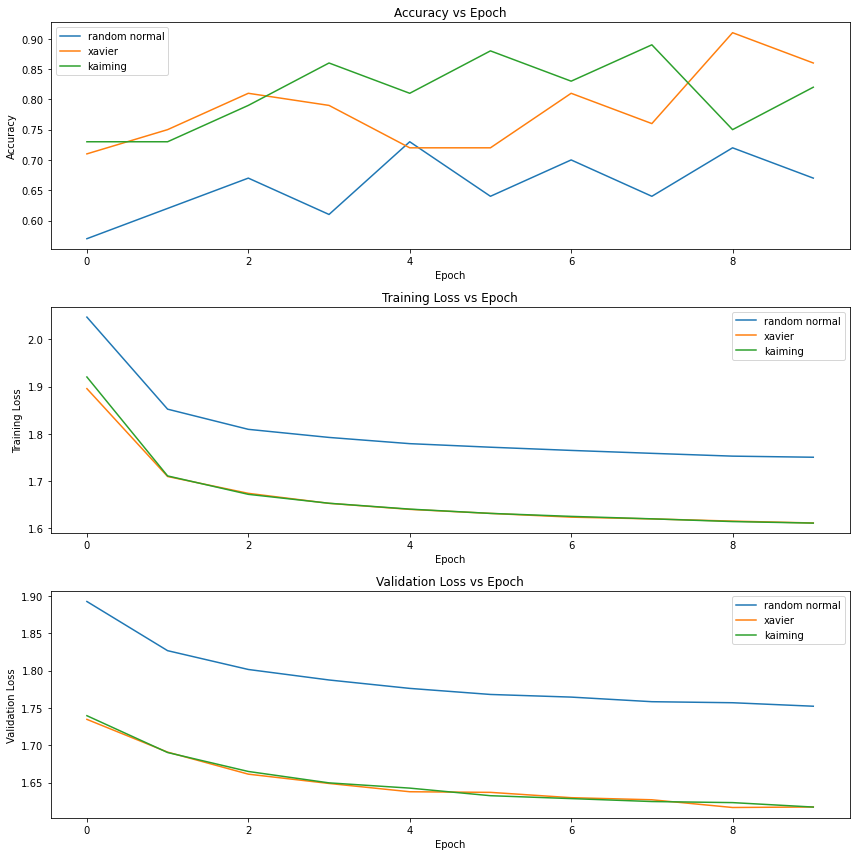

In [37]:
f,ax=plt.subplots(nrows=3,figsize=(12,12))
ax[0].plot(acc_rn,label='random normal')
ax[0].plot(acc_xavier,label='xavier')
ax[0].plot(acc_kaiming,label='kaiming')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs Epoch')
ax[0].legend()

ax[1].plot(train_loss_rn,label='random normal')
ax[1].plot(train_loss_xavier,label='xavier')
ax[1].plot(train_loss_kaiming,label='kaiming')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Training Loss')
ax[1].set_title('Training Loss vs Epoch')
ax[1].legend()

ax[2].plot(val_loss_rn,label='random normal')
ax[2].plot(val_loss_xavier,label='xavier')
ax[2].plot(val_loss_kaiming,label='kaiming')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Validation Loss')
ax[2].set_title('Validation Loss vs Epoch')
ax[2].legend()
plt.tight_layout()

It looks as if random normal does not perform well compared to xavier and kaiming initialization. It is surpirsing to me that weight initialization actually has a significant effect on training. This translates to a tangible difference in accuracy of the model. I will use kaiming initialization going forward.

## 4. Try normalization like batch normalization or layer normalization, whether these normalization methods can help your training or improve your performance?


In [43]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    nn.init.kaiming_normal_(self.layer1.weight)
    self.layer2 = nn.Linear(300, 150)
    self.layer2_bn= nn.BatchNorm1d(150)
    self.layer3 = nn.Linear(150, 75)
    self.layer3_bn = nn.BatchNorm1d(75)
    self.layer4 = nn.Linear(75, 10) 
    self.dropout = nn.Dropout(0.3)
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = self.dropout(F.relu(self.layer1(x)))
    x = self.layer2(x)
    x = self.dropout(F.relu(self.layer2_bn(x)))
    x = self.layer3(x)
    x = self.dropout(F.relu(self.layer3_bn(x)))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [44]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = optimizers[1]
loss_fn   = nn.CrossEntropyLoss() 

epochs = 10

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 10/10 [02:13<00:00, 13.35s/it]


Text(0.5, 0.98, 'Adam (with kaiming initialization and batch normalization) \n lr = 0.0001 epochs = 10 \n Max Accuracy = 0.890')

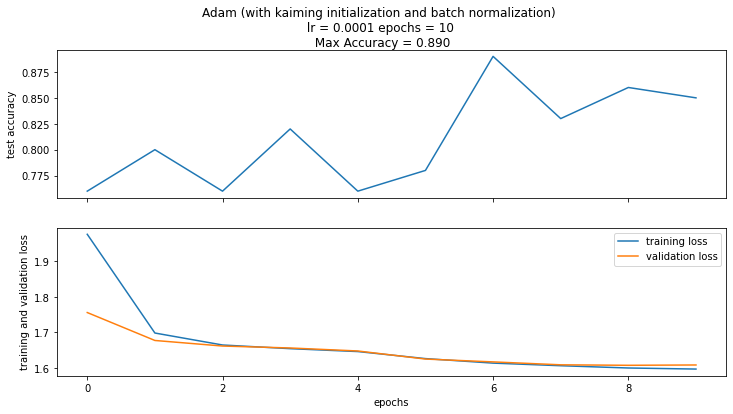

In [40]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam (with kaiming initialization and batch normalization) \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

As shown above, it seems like batch normalization does indeed have a slight positive effect on training. More than anything else it looks like this sped things up.

## 5. To further improve the performance, you can also choose your own hyperparameters, including:
- Number of layers
- Number of neurons in each layer
- Learning rate
- Number of training epochs

What was the accuracy on the test set for your best-performing network?

The accuracy for my best performing network was ~93%. I achieved this through 3 linear layers, with 300,150,75 neurons using relu. I used Adam with lr = 0.0001 and 20 epochs, dropout of 0.5, kaiming initialization and batch normalization. This model is shown below.

In [51]:
#Define your network:
class Network(nn.Module):
  def __init__(self,input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super(Network, self).__init__()
    self.layer1 = nn.Linear(input_dim, 300)
    nn.init.kaiming_normal_(self.layer1.weight)
    self.layer2 = nn.Linear(300, 150)
    self.layer2_bn= nn.BatchNorm1d(150)
    self.layer3 = nn.Linear(150, 75)
    self.layer3_bn = nn.BatchNorm1d(75)
    self.layer4 = nn.Linear(75, 10) 
    self.dropout = nn.Dropout(0.5)
  def forward(self, input):
    #How does your model process the input?
    x = input.view(input.shape[0],-1)
    x = self.dropout(F.relu(self.layer1(x)))
    x = self.layer2(x)
    x = self.dropout(F.relu(self.layer2_bn(x)))
    x = self.layer3(x)
    x = self.dropout(F.relu(self.layer3_bn(x)))
    output = F.softmax(self.layer4(x), dim=1)
    return output

In [52]:
# Define your optimizer and loss fn
model = Network(input_dim)
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01),torch.optim.Adam(model.parameters(),lr = 0.0001),torch.optim.RMSprop(model.parameters(),lr = 0.0001)]
optimizer = optimizers[1]
loss_fn   = nn.CrossEntropyLoss() 

epochs = 20

# initialize arrays to hold t loss and accuracy data
train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in tqdm.trange(epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  for imgs,labels in val_loader:
    y_pred = model(imgs)
    loss = loss_fn(y_pred, labels)
    total_val_loss += loss
  val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 20/20 [04:06<00:00, 12.30s/it]


Text(0.5, 0.98, 'Adam (with kaiming initialization and batch normalization) \n lr = 0.0001 epochs = 20 \n Max Accuracy = 0.920')

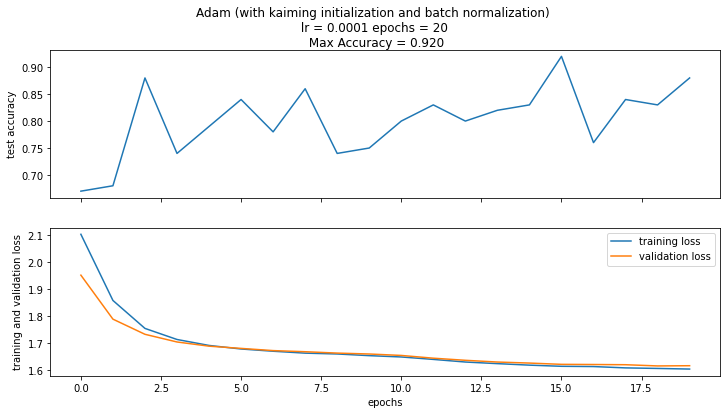

In [53]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("test accuracy")
ax2.plot(train_loss_list,label='training loss')
ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam (with kaiming initialization and batch normalization) \n lr = 0.0001 epochs = {epochs} \n Max Accuracy = {max(accuracy_list):.3f}')